# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

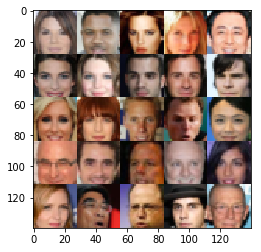

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name="input_real")
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32)
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/usr/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/usr/lo

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        # relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        # relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        # Flatten it
        flat = tf.reshape(x2, (-1, 7*7*128))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        # x1 = tf.layers.batch_normalization(x1, training=is_train)
        # x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256 now
                
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        # x2 = tf.layers.batch_normalization(x2, training=is_train)
        # x2 = tf.maximum(alpha * x2, x2)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x5 now
        out = tf.tanh(logits)
        
        return out
    
    return None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
    print("data ",data_shape, data_image_mode)
    
    losses = []
    steps = 0
    
    
    input_real, input_z, input_learning_rate = model_inputs(
        data_shape[1],data_shape[2],data_shape[3], z_dim)
        
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, input_learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, input_learning_rate:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, input_learning_rate:learning_rate})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 6*12, input_z, data_shape[3],data_image_mode)
                    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

data  (60000, 28, 28, 1) L
Epoch 1/2... Discriminator Loss: 0.8183... Generator Loss: 0.6565
Epoch 1/2... Discriminator Loss: 0.9312... Generator Loss: 0.6245
Epoch 1/2... Discriminator Loss: 1.1362... Generator Loss: 0.5637
Epoch 1/2... Discriminator Loss: 1.2470... Generator Loss: 0.6608
Epoch 1/2... Discriminator Loss: 1.2376... Generator Loss: 0.8145
Epoch 1/2... Discriminator Loss: 1.4260... Generator Loss: 0.7856
Epoch 1/2... Discriminator Loss: 1.4289... Generator Loss: 0.7851
Epoch 1/2... Discriminator Loss: 1.3492... Generator Loss: 0.7673
Epoch 1/2... Discriminator Loss: 1.5017... Generator Loss: 0.7009
Epoch 1/2... Discriminator Loss: 1.6328... Generator Loss: 0.6464


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 1/2... Discriminator Loss: 1.5445... Generator Loss: 0.6904
Epoch 1/2... Discriminator Loss: 1.3872... Generator Loss: 0.7286
Epoch 1/2... Discriminator Loss: 1.4305... Generator Loss: 0.7621
Epoch 1/2... Discriminator Loss: 1.4278... Generator Loss: 0.7659
Epoch 1/2... Discriminator Loss: 1.4322... Generator Loss: 0.6974
Epoch 1/2... Discriminator Loss: 1.3753... Generator Loss: 0.6960
Epoch 1/2... Discriminator Loss: 1.3472... Generator Loss: 0.6754
Epoch 1/2... Discriminator Loss: 1.4924... Generator Loss: 0.6305
Epoch 1/2... Discriminator Loss: 1.5315... Generator Loss: 0.6193
Epoch 1/2... Discriminator Loss: 1.4359... Generator Loss: 0.6597


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 1/2... Discriminator Loss: 1.3545... Generator Loss: 0.6788
Epoch 1/2... Discriminator Loss: 1.3863... Generator Loss: 0.6650
Epoch 1/2... Discriminator Loss: 1.4259... Generator Loss: 0.6173
Epoch 1/2... Discriminator Loss: 1.3942... Generator Loss: 0.6904
Epoch 1/2... Discriminator Loss: 1.4600... Generator Loss: 0.6709
Epoch 1/2... Discriminator Loss: 1.4338... Generator Loss: 0.6857
Epoch 1/2... Discriminator Loss: 1.3399... Generator Loss: 0.7251
Epoch 1/2... Discriminator Loss: 1.3595... Generator Loss: 0.6651
Epoch 1/2... Discriminator Loss: 1.4715... Generator Loss: 0.6297
Epoch 1/2... Discriminator Loss: 1.4658... Generator Loss: 0.6473


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 1/2... Discriminator Loss: 1.4220... Generator Loss: 0.6875
Epoch 1/2... Discriminator Loss: 1.3880... Generator Loss: 0.7077
Epoch 1/2... Discriminator Loss: 1.3781... Generator Loss: 0.7111
Epoch 1/2... Discriminator Loss: 1.3683... Generator Loss: 0.7545
Epoch 1/2... Discriminator Loss: 1.3954... Generator Loss: 0.7248
Epoch 1/2... Discriminator Loss: 1.4461... Generator Loss: 0.6353
Epoch 1/2... Discriminator Loss: 1.4739... Generator Loss: 0.6632
Epoch 1/2... Discriminator Loss: 1.3949... Generator Loss: 0.7170
Epoch 1/2... Discriminator Loss: 1.3744... Generator Loss: 0.6985
Epoch 1/2... Discriminator Loss: 1.4593... Generator Loss: 0.6404


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 1/2... Discriminator Loss: 1.4230... Generator Loss: 0.6933
Epoch 1/2... Discriminator Loss: 1.4257... Generator Loss: 0.6730
Epoch 1/2... Discriminator Loss: 1.4250... Generator Loss: 0.6480
Epoch 1/2... Discriminator Loss: 1.3921... Generator Loss: 0.6667
Epoch 1/2... Discriminator Loss: 1.3784... Generator Loss: 0.6602
Epoch 1/2... Discriminator Loss: 1.4049... Generator Loss: 0.6195
Epoch 2/2... Discriminator Loss: 1.4165... Generator Loss: 0.6506
Epoch 2/2... Discriminator Loss: 1.3965... Generator Loss: 0.6477
Epoch 2/2... Discriminator Loss: 1.3969... Generator Loss: 0.6635
Epoch 2/2... Discriminator Loss: 1.3976... Generator Loss: 0.7001


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 2/2... Discriminator Loss: 1.3723... Generator Loss: 0.7460
Epoch 2/2... Discriminator Loss: 1.4374... Generator Loss: 0.6684
Epoch 2/2... Discriminator Loss: 1.4775... Generator Loss: 0.6714
Epoch 2/2... Discriminator Loss: 1.4227... Generator Loss: 0.7041
Epoch 2/2... Discriminator Loss: 1.3786... Generator Loss: 0.7096
Epoch 2/2... Discriminator Loss: 1.3709... Generator Loss: 0.7107
Epoch 2/2... Discriminator Loss: 1.3788... Generator Loss: 0.6951
Epoch 2/2... Discriminator Loss: 1.3650... Generator Loss: 0.7500
Epoch 2/2... Discriminator Loss: 1.4085... Generator Loss: 0.6827
Epoch 2/2... Discriminator Loss: 1.4347... Generator Loss: 0.6795


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 2/2... Discriminator Loss: 1.4364... Generator Loss: 0.6697
Epoch 2/2... Discriminator Loss: 1.4102... Generator Loss: 0.6863
Epoch 2/2... Discriminator Loss: 1.4070... Generator Loss: 0.7046
Epoch 2/2... Discriminator Loss: 1.3780... Generator Loss: 0.6956
Epoch 2/2... Discriminator Loss: 1.3934... Generator Loss: 0.6850
Epoch 2/2... Discriminator Loss: 1.4312... Generator Loss: 0.6371
Epoch 2/2... Discriminator Loss: 1.4359... Generator Loss: 0.6356
Epoch 2/2... Discriminator Loss: 1.3932... Generator Loss: 0.7070
Epoch 2/2... Discriminator Loss: 1.4019... Generator Loss: 0.6836
Epoch 2/2... Discriminator Loss: 1.4265... Generator Loss: 0.6787


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 2/2... Discriminator Loss: 1.4032... Generator Loss: 0.6872
Epoch 2/2... Discriminator Loss: 1.4091... Generator Loss: 0.6532
Epoch 2/2... Discriminator Loss: 1.4309... Generator Loss: 0.6296
Epoch 2/2... Discriminator Loss: 1.3836... Generator Loss: 0.6924
Epoch 2/2... Discriminator Loss: 1.3662... Generator Loss: 0.7416
Epoch 2/2... Discriminator Loss: 1.4213... Generator Loss: 0.6867
Epoch 2/2... Discriminator Loss: 1.3919... Generator Loss: 0.7022
Epoch 2/2... Discriminator Loss: 1.4090... Generator Loss: 0.6710
Epoch 2/2... Discriminator Loss: 1.4044... Generator Loss: 0.6814
Epoch 2/2... Discriminator Loss: 1.3890... Generator Loss: 0.7051


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 2/2... Discriminator Loss: 1.3829... Generator Loss: 0.7285
Epoch 2/2... Discriminator Loss: 1.4246... Generator Loss: 0.7018
Epoch 2/2... Discriminator Loss: 1.4152... Generator Loss: 0.7116
Epoch 2/2... Discriminator Loss: 1.4063... Generator Loss: 0.6949
Epoch 2/2... Discriminator Loss: 1.4097... Generator Loss: 0.6703
Epoch 2/2... Discriminator Loss: 1.4254... Generator Loss: 0.6548
Epoch 2/2... Discriminator Loss: 1.4013... Generator Loss: 0.6717
Epoch 2/2... Discriminator Loss: 1.4302... Generator Loss: 0.6784
Epoch 2/2... Discriminator Loss: 1.4229... Generator Loss: 0.6546


KeyboardInterrupt: 

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

data  (202599, 28, 28, 3) RGB
Epoch 1/1... Discriminator Loss: 0.9230... Generator Loss: 0.6621
Epoch 1/1... Discriminator Loss: 0.9054... Generator Loss: 0.6511
Epoch 1/1... Discriminator Loss: 1.1536... Generator Loss: 0.6376
Epoch 1/1... Discriminator Loss: 0.9131... Generator Loss: 0.8294
Epoch 1/1... Discriminator Loss: 1.5189... Generator Loss: 0.7958
Epoch 1/1... Discriminator Loss: 1.2909... Generator Loss: 0.8481
Epoch 1/1... Discriminator Loss: 1.4597... Generator Loss: 0.6897
Epoch 1/1... Discriminator Loss: 1.3449... Generator Loss: 0.7412
Epoch 1/1... Discriminator Loss: 1.4986... Generator Loss: 0.6771
Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 0.8113


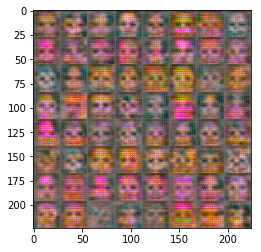

Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.6724
Epoch 1/1... Discriminator Loss: 1.7211... Generator Loss: 0.5587
Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 0.6721
Epoch 1/1... Discriminator Loss: 1.2376... Generator Loss: 0.7472
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.6266
Epoch 1/1... Discriminator Loss: 1.5958... Generator Loss: 0.6080
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.6540
Epoch 1/1... Discriminator Loss: 1.3774... Generator Loss: 0.6375
Epoch 1/1... Discriminator Loss: 1.4841... Generator Loss: 0.6433
Epoch 1/1... Discriminator Loss: 1.6106... Generator Loss: 0.6177


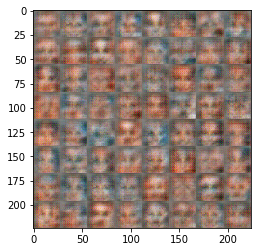

Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.7437
Epoch 1/1... Discriminator Loss: 1.3457... Generator Loss: 0.7296
Epoch 1/1... Discriminator Loss: 1.3607... Generator Loss: 0.6811
Epoch 1/1... Discriminator Loss: 1.5161... Generator Loss: 0.6510
Epoch 1/1... Discriminator Loss: 1.4942... Generator Loss: 0.6189
Epoch 1/1... Discriminator Loss: 1.4341... Generator Loss: 0.6326
Epoch 1/1... Discriminator Loss: 1.4438... Generator Loss: 0.6517
Epoch 1/1... Discriminator Loss: 1.4493... Generator Loss: 0.6461
Epoch 1/1... Discriminator Loss: 1.3492... Generator Loss: 0.6941
Epoch 1/1... Discriminator Loss: 1.4742... Generator Loss: 0.6404


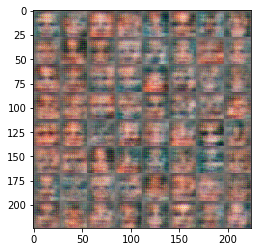

Epoch 1/1... Discriminator Loss: 1.5737... Generator Loss: 0.6296
Epoch 1/1... Discriminator Loss: 1.4449... Generator Loss: 0.6741
Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 0.6724
Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 0.6451
Epoch 1/1... Discriminator Loss: 1.5017... Generator Loss: 0.6446
Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.7026
Epoch 1/1... Discriminator Loss: 1.4519... Generator Loss: 0.6720
Epoch 1/1... Discriminator Loss: 1.5322... Generator Loss: 0.6673
Epoch 1/1... Discriminator Loss: 1.4437... Generator Loss: 0.7172
Epoch 1/1... Discriminator Loss: 1.4131... Generator Loss: 0.6723


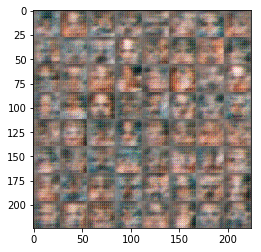

Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.6835
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.7109
Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 0.6484
Epoch 1/1... Discriminator Loss: 1.4468... Generator Loss: 0.6397
Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.6529
Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 0.6416
Epoch 1/1... Discriminator Loss: 1.5879... Generator Loss: 0.5738
Epoch 1/1... Discriminator Loss: 1.4099... Generator Loss: 0.7102
Epoch 1/1... Discriminator Loss: 1.3478... Generator Loss: 0.7720
Epoch 1/1... Discriminator Loss: 1.4957... Generator Loss: 0.6777


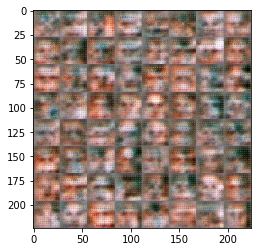

Epoch 1/1... Discriminator Loss: 1.5333... Generator Loss: 0.5895
Epoch 1/1... Discriminator Loss: 1.5230... Generator Loss: 0.6661
Epoch 1/1... Discriminator Loss: 1.4390... Generator Loss: 0.6636
Epoch 1/1... Discriminator Loss: 1.4515... Generator Loss: 0.6251
Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 0.7026
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.6775
Epoch 1/1... Discriminator Loss: 1.4553... Generator Loss: 0.5993
Epoch 1/1... Discriminator Loss: 1.5013... Generator Loss: 0.6218
Epoch 1/1... Discriminator Loss: 1.5047... Generator Loss: 0.6735
Epoch 1/1... Discriminator Loss: 1.5380... Generator Loss: 0.6842


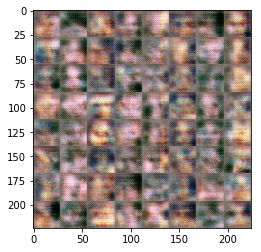

Epoch 1/1... Discriminator Loss: 1.4333... Generator Loss: 0.6950
Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.6605
Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 0.6464
Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 0.6657
Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.7201
Epoch 1/1... Discriminator Loss: 1.4700... Generator Loss: 0.6851
Epoch 1/1... Discriminator Loss: 1.4924... Generator Loss: 0.7192
Epoch 1/1... Discriminator Loss: 1.4480... Generator Loss: 0.6829
Epoch 1/1... Discriminator Loss: 1.4400... Generator Loss: 0.6551
Epoch 1/1... Discriminator Loss: 1.4134... Generator Loss: 0.6499


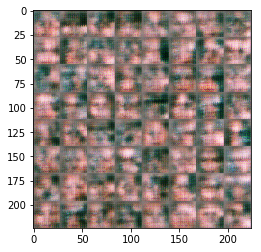

Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.7069
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.7280
Epoch 1/1... Discriminator Loss: 1.4884... Generator Loss: 0.6406


In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.